## Importing libraries

In [40]:
import nltk
import pandas as pd
import numpy as np
import re
import seaborn as sn
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, ShuffleSplit, cross_val_predict, KFold

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Loading and pre-processing the data

Loading the data with a ',' (comma) separator. 

In [41]:
# We use the sample function to take randomly n rows because the dataset is too long (1.6m rows) 
dataset = pd.read_csv('english_tweets.csv', sep = ',', encoding='utf8').sample(n = 30000, random_state = 1)
dataset['label'] = dataset['label'].replace(4, 1)

# Reset index after the sample function 
dataset.reset_index(drop = True, inplace = True)

Loading stopwords from the dedicated NLTK library.

In [42]:
stop_words_en = set(stopwords.words("english"))

Functions to pre-process the text by removing any useless stuff.
We choosed 2 preprocessing :
  - One by using lemmatization
  - One by not using lemmatization (default)

We removed stop_words in both functions.

In [43]:
def preprocessWithLemmatization(column):
    corpus = []
    
    lemmatizer = WordNetLemmatizer()
    
    for i in range(0, len(column)):
        # Remove sites and twitter tags
        text = re.sub('(http[^\s]+|@[^\s]+)', ' ', column.iloc[i])
        
        # Remove punctuations
        text = re.sub('[^A-Za-zÀ-ÖØ-öø-ÿ]', ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Convert to list from string
        text = text.split() 
        
        # Lemmatization of each word of a row
        for word in text:
            word = lemmatizer.lemmatize(word);
        
        # Remove stop words
        text = ' '.join(word.strip() for word in text if not word in stop_words_en)

        corpus.append(text)
        
    return corpus

def preprocessWithoutLemmatization(column):
    corpus = []
    
    for i in range(0, len(column)):
        # Remove sites and twitter tags
        text = re.sub('(http[^\s]+|@[^\s]+)', ' ', column.iloc[i])
        
        # Remove punctuations
        text = re.sub('[^A-Za-zÀ-ÖØ-öø-ÿ]', ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Convert to list from string
        text = text.split() 
        
        # Remove stop words
        text = ' '.join(word.strip() for word in text if not word in stop_words_en)

        corpus.append(text)
        
    return corpus

Transform words to numbers by using the TF-IDF vectorizer.

In [44]:
tfidf = TfidfVectorizer(stop_words = stop_words_en)

datasetWithLemmatization = dataset
datasetWithoutLemmatization = dataset

datasetWithLemmatization['text'] = preprocessWithLemmatization(datasetWithLemmatization['text'])
datasetWithoutLemmatization['text'] = preprocessWithoutLemmatization(datasetWithoutLemmatization['text'])

datasetWithLemmatizationX = tfidf.fit_transform(datasetWithLemmatization['text'])
datasetWithLemmatizationY = datasetWithLemmatization['label']

datasetWithoutLemmatizationX = tfidf.fit_transform(datasetWithoutLemmatization['text'])
datasetWithoutLemmatizationY = datasetWithoutLemmatization['label']

## Build and compare classifiers using cross validation method 

Function that cross validates and creates the confusion matrix for each of our instance of algorithms. We choosed to cross validate using 5 splits.
The function returns an array with all the data needed to compare them with each other : accuracy, precision, recall, f1 score, confusion matrix and execution time.

In [45]:
def scores(clf, X, y):
    confusionMatrixArray = []

    # Randomly split the dataset in 5 parts 
    kf = KFold(n_splits = 5, shuffle = True, random_state = 1)

    accuracyArray, precisionArray, recallArray, f1Array, timeArray = [], [], [], [], []
    
    # Test each split (from KFold) while the others are used for training (repeated 5 times)
    for train_index, test_index in kf.split(X):
        startTime = time.time()

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Training for 4/5 splits
        clf.fit(X_train, y_train)

        # Testing for 1/5 splits
        y_pred = clf.predict(X_test)

        # Saving scores in array
        accuracyArray.append(metrics.accuracy_score(y_test, y_pred))
        precisionArray.append(metrics.precision_score(y_test, y_pred))
        recallArray.append(metrics.recall_score(y_test, y_pred))
        f1Array.append(metrics.f1_score(y_test, y_pred))

        confusionMatrixArray.append(confusion_matrix(y_test, y_pred))

        endTime = time.time()

        timeArray.append(endTime - startTime)

    # Compute the mean value of each score/confusion matrix
    confusionMatrix = np.mean(confusionMatrixArray, axis = 0)

    accuracy = np.mean(accuracyArray)
    precision = np.mean(precisionArray)
    recall = np.mean(recallArray)
    f1 = np.mean(f1Array)
    
    executionTime = np.mean(timeArray)
    
    return [accuracy, precision, recall, f1, confusionMatrix, executionTime]

Function that takes a score array and a title and then prints the accuracy, precision, recall, f1 score, execution time and confusion matrix of a classifier.

In [46]:
def printScores(scoresArray, title):
    print(title)
    print('  - Accuracy : {0:.2f} %'.format(scoresArray[0] * 100))
    print('  - Precision : {0:.2f} %'.format(scoresArray[1] * 100))
    print('  - Recall : {0:.2f} %'.format(scoresArray[2] * 100))
    print('  - F1 : {0:.2f} %'.format(scoresArray[3] * 100))
    print('Mean time elapsed : {0:.3f} seconds'.format(scoresArray[5]))
    
    # Plot the confusion matrix
    confusionMatrixDataframe = pd.DataFrame(scoresArray[4], range(2), range(2))
    sn.set(font_scale = 1.4)
    sn.heatmap(confusionMatrixDataframe, annot = True, annot_kws = {"size": 16})
    plt.show()

Create both classifiers (Random Forest Classifier and Logistic Regression).

Finally, we print scores of both algorithms (with the different preprocessing).

Scores of RFC with lemmatization :
  - Accuracy : 72.76 %
  - Precision : 72.34 %
  - Recall : 74.09 %
  - F1 : 73.20 %
Mean time elapsed : 82.486 seconds


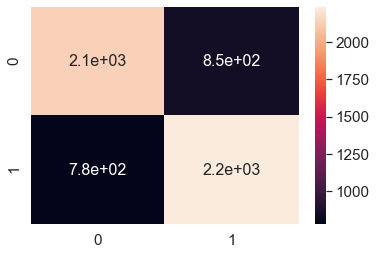

Scores of RFC without lemmatization :
  - Accuracy : 72.80 %
  - Precision : 72.38 %
  - Recall : 74.14 %
  - F1 : 73.24 %
Mean time elapsed : 82.451 seconds


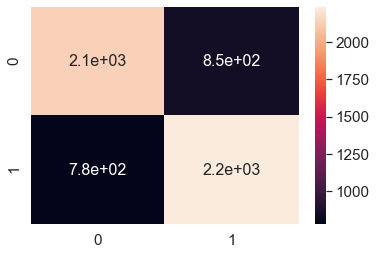

Scores of LR with lemmatization :
  - Accuracy : 74.29 %
  - Precision : 73.38 %
  - Recall : 76.61 %
  - F1 : 74.95 %
Mean time elapsed : 0.209 seconds


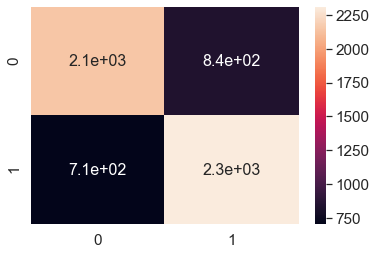

Scores of LR without lemmatization :
  - Accuracy : 74.29 %
  - Precision : 73.38 %
  - Recall : 76.61 %
  - F1 : 74.95 %
Mean time elapsed : 0.206 seconds


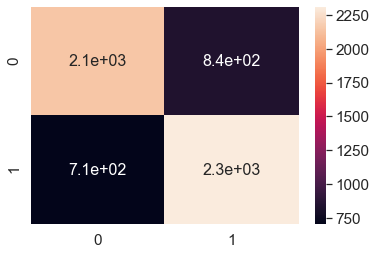

In [47]:
rfc = RandomForestClassifier(n_estimators = 100)

reg = LogisticRegression()

scoresRfcWithLemmatization = scores(rfc, datasetWithLemmatizationX, datasetWithLemmatizationY)
printScores(scoresRfcWithLemmatization, 'Scores of RFC with lemmatization :')

scoresRfcWithoutLemmatization = scores(rfc, datasetWithoutLemmatizationX, datasetWithoutLemmatizationY)
printScores(scoresRfcWithoutLemmatization, 'Scores of RFC without lemmatization :')

scoresLrWithLemmatization = scores(reg, datasetWithLemmatizationX, datasetWithLemmatizationY)
printScores(scoresLrWithLemmatization, 'Scores of LR with lemmatization :')

scoresLrWithoutLemmatization = scores(reg, datasetWithoutLemmatizationX, datasetWithoutLemmatizationY)
printScores(scoresLrWithoutLemmatization, 'Scores of LR without lemmatization :')

## Results and conclusion

We can first note that "Random Forest Classifier" is very long to train and predict while "Logistic Regression" is under 1 second.

Moreover, it seems that lemmatization has no effect on both classifiers.

LR is slightly better in average than RFC and takes less time to compute. 